In [3]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import torch.optim as optim
from rich.progress import Progress, SpinnerColumn, BarColumn, TextColumn, Live
import pickle
from Posture_ensemble_model import PostureLSTMModel, PostureGRUModel, PostureTemporalConvNet, PostureEnsembleModel
import torch.nn as nn
import argparse
import sys

def main(time_step):
    """
    主函數，用於訓練姿態集成模型。
    
    參數:
    - time_step: int，滑動窗口的大小。
    
    功能:
    - 加載數據並進行標籤編碼。
    - 創建數據集和數據加載器。
    - 初始化模型和訓練相關的參數。
    - 訓練和評估模型。
    - 保存訓練好的模型。
    """
    # 加載數據
    loaded = np.load('data_combined.npz')
    data_slices = loaded['data']
    labels = loaded['labels']

    # 創建LabelEncoder並進行編碼
    label_encoder = LabelEncoder()
    int_labels = label_encoder.fit_transform(labels)

    # 保存LabelEncoder到.pkl文件
    with open('Model/posture_label_encoder.pkl', 'wb') as f:
        pickle.dump(label_encoder, f)

    # 打印標籤列表
    print(f'Labels: {label_encoder.classes_}')

    # 創建數據集和數據加載器
    class SkeletonDataset(Dataset):
        """
        自定義數據集類別，用於加載骨架數據。
        
        參數:
        - data: numpy.ndarray，數據片段。
        - labels: numpy.ndarray，數據標籤。
        """
        def __init__(self, data, labels):
            self.data = data
            self.labels = labels

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

    train_dataset = SkeletonDataset(data_slices, int_labels)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    # 設置參數
    input_dim = 33 * 4  # 33 keypoints * 4 coords (xyzv)
    hidden_dim = 128
    num_layers = 2
    num_classes = len(label_encoder.classes_)
    tcn_channels = [128, 128]

    lstm_model = PostureLSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, num_classes=num_classes)
    gru_model = PostureGRUModel(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, num_classes=num_classes)
    tcn_model = PostureTemporalConvNet(num_inputs=input_dim, num_channels=tcn_channels, num_classes=num_classes, dropout=0.2)

    # 創建集成模型
    model = PostureEnsembleModel(lstm_model, gru_model, tcn_model, num_classes=num_classes)

    # 將模型移動到GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # 訓練函數
    def train_model(model, train_loader, criterion, optimizer, num_epochs=20):
        """
        訓練模型。
        
        參數:
        - model: nn.Module，待訓練的模型。
        - train_loader: DataLoader，訓練數據加載器。
        - criterion: 損失函數。
        - optimizer: 優化器。
        - num_epochs: int，訓練的輪數。
        
        功能:
        - 訓練模型並顯示訓練進度。
        """
        progress = Progress(
            SpinnerColumn(), 
            BarColumn(), 
            TextColumn("[progress.percentage]{task.percentage:>3.1f}%"), 
            TextColumn("[progress.description]{task.description}"),
            auto_refresh=True
        )

        with Live(progress, refresh_per_second=10):
            train_task = progress.add_task(
                description="Initializing...", 
                total=num_epochs * len(train_loader)
            )
            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0
                
                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    inputs = inputs.view(inputs.size(0), time_step, -1)  # 形狀為 (batch_size, frames, keypoints * coords)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()
                    progress.update(
                        train_task,
                        description=f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}",
                        advance=1
                    )

    # 評估函數
    def evaluate_model(model, test_file_path):
        """
        評估模型。
        
        參數:
        - model: nn.Module，待評估的模型。
        - test_file_path: str，測試數據的文件路徑。
        
        功能:
        - 評估模型並顯示評估進度。
        - 計算每一個動作的正確率。
        """
        model.eval()
        total_correct = 0
        total_samples = 0
        action_correct = {}
        action_total = {}

        progress = Progress(
            SpinnerColumn(), 
            BarColumn(), 
            TextColumn("[progress.percentage]{task.percentage:>3.1f}%"), 
            TextColumn("[progress.description]{task.description}"),
            auto_refresh=True
        )
        
        # 加載測試數據
        loaded_test = np.load(test_file_path)
        test_data_slices = loaded_test['data']
        test_labels = loaded_test['labels']

        # 創建測試數據集和數據加載器
        test_dataset = SkeletonDataset(test_data_slices, label_encoder.transform(test_labels))
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

        with Live(progress, refresh_per_second=10):
            eval_task = progress.add_task("Evaluating", total=len(test_loader))
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    inputs = inputs.view(1, time_step, -1)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    action = label_encoder.inverse_transform([labels.item()])[0]

                    total_samples += 1
                    if action not in action_total:
                        action_total[action] = 0
                        action_correct[action] = 0
                    action_total[action] += 1
                    if predicted.item() == labels.item():
                        total_correct += 1
                        action_correct[action] += 1

                    progress.update(eval_task, advance=1)

        overall_accuracy = 100 * total_correct / total_samples
        print(f'Overall Accuracy of the model on the test set: {overall_accuracy:.2f}%')

        for action in action_correct:
            action_accuracy = 100 * action_correct[action] / action_total[action]
            print(f'Accuracy for action {action}: {action_accuracy:.2f}%')

    # 訓練模型
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_model(model, train_loader, criterion, optimizer, num_epochs=128)

    # 評估模型
    evaluate_model(model, 'test_data.npz')

    # 保存模型
    torch.save({
        'lstm_model_state_dict': lstm_model.state_dict(),
        'gru_model_state_dict': gru_model.state_dict(),
        'tcn_model_state_dict': tcn_model.state_dict(),
        'ensemble_model_state_dict': model.state_dict()
    }, r"Model/Posture_ensemble_model.pth")

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Train the Posture Ensemble Model.")
    parser.add_argument("--time_step", type=int, default=70, help="The size of the time step for the sliding window.")
    # 如果在 Jupyter Notebook 中運行，跳過 argparse
    if "ipykernel" in sys.modules:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()

    main(args.time_step)


Output()

Labels: ['Bent_Leg_Kickback' 'Bent_Over_Row' 'Bird_Dog' 'Crunch_Floor' 'Dead_Bug'
 'Deadlift' 'Farmers_walk' 'Front_Plank' 'Kettlebell_Strict_Press'
 'Mountain_Climber' 'Prone' 'Resistance_Band_Side_Walk' 'Russian_Twist'
 'Squat' 'glute-bridge' 'push_up']


Output()

Overall Accuracy of the model on the test set: 67.53%
Accuracy for action Bent_Leg_Kickback: 90.57%
Accuracy for action Bent_Over_Row: 11.76%
Accuracy for action Bird_Dog: 52.45%
Accuracy for action Crunch_Floor: 75.76%
Accuracy for action Deadlift: 72.34%
Accuracy for action Dead_Bug: 100.00%
Accuracy for action Farmers_walk: 100.00%
Accuracy for action Front_Plank: 100.00%
Accuracy for action glute-bridge: 100.00%
Accuracy for action Kettlebell_Strict_Press: 100.00%
Accuracy for action Mountain_Climber: 0.00%
Accuracy for action Prone: 0.00%
Accuracy for action push_up: 100.00%
Accuracy for action Resistance_Band_Side_Walk: 85.71%
Accuracy for action Russian_Twist: 100.00%
Accuracy for action Squat: 100.00%


Output()

Labels: ['Bent_Leg_Kickback' 'Bent_Over_Row' 'Bird_Dog' 'Crunch_Floor' 'Dead_Bug'
 'Deadlift' 'Farmers_walk' 'Front_Plank' 'Kettlebell_Strict_Press'
 'Mountain_Climber' 'Prone' 'Resistance_Band_Side_Walk' 'Russian_Twist'
 'Squat' 'glute-bridge' 'push_up']


Output()

Overall Accuracy of the model on the test set: 47.57%
Accuracy for action Bent_Leg_Kickback: 0.00%
Accuracy for action Bent_Over_Row: 0.00%
Accuracy for action Bird_Dog: 31.79%
Accuracy for action Crunch_Floor: 63.64%
Accuracy for action Deadlift: 100.00%
Accuracy for action Dead_Bug: 99.69%
Accuracy for action Farmers_walk: 80.00%
Accuracy for action Front_Plank: 100.00%
Accuracy for action glute-bridge: 40.74%
Accuracy for action Kettlebell_Strict_Press: 100.00%
Accuracy for action Mountain_Climber: 12.10%
Accuracy for action Prone: 100.00%
Accuracy for action push_up: 0.00%
Accuracy for action Resistance_Band_Side_Walk: 80.95%
Accuracy for action Russian_Twist: 100.00%
Accuracy for action Squat: 69.57%


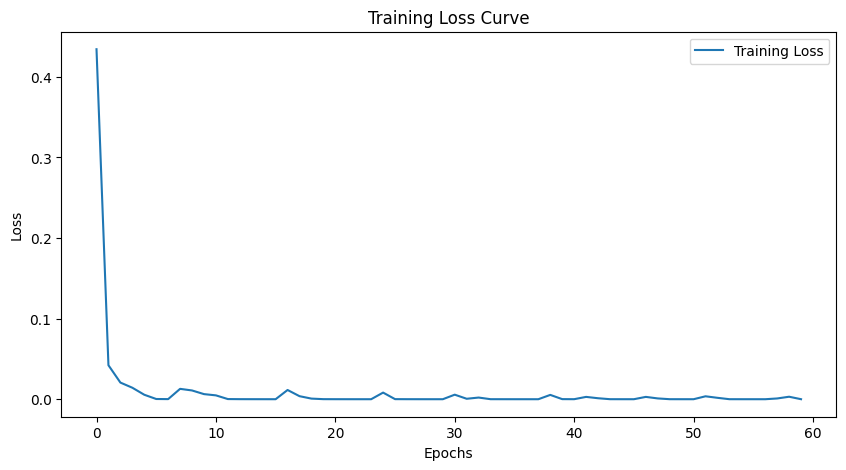

In [9]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import torch.optim as optim
from rich.progress import Progress, SpinnerColumn, BarColumn, TextColumn, Live
import pickle
from Posture_ensemble_model import PostureLSTMModel, PostureGRUModel, PostureTemporalConvNet, PostureEnsembleModel
import torch.nn as nn
import argparse
import sys
import matplotlib.pyplot as plt

def main(time_step):
    """
    主函數，用於訓練姿態集成模型。
    
    參數:
    - time_step: int，滑動窗口的大小。
    
    功能:
    - 加載數據並進行標籤編碼。
    - 創建數據集和數據加載器。
    - 初始化模型和訓練相關的參數。
    - 訓練和評估模型。
    - 保存訓練好的模型。
    """
    # 加載數據
    loaded = np.load('data_combined_augmented.npz')
    data_slices = loaded['data']
    labels = loaded['labels']

    # 創建LabelEncoder並進行編碼
    label_encoder = LabelEncoder()
    int_labels = label_encoder.fit_transform(labels)

    # 保存LabelEncoder到.pkl文件
    with open('Model/posture_label_encoder.pkl', 'wb') as f:
        pickle.dump(label_encoder, f)

    # 打印標籤列表
    print(f'Labels: {label_encoder.classes_}')

    # 創建數據集和數據加載器
    class SkeletonDataset(Dataset):
        """
        自定義數據集類別，用於加載骨架數據。
        
        參數:
        - data: numpy.ndarray，數據片段。
        - labels: numpy.ndarray，數據標籤。
        """
        def __init__(self, data, labels):
            self.data = data
            self.labels = labels

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

    train_dataset = SkeletonDataset(data_slices, int_labels)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    # 設置參數
    input_dim = 33 * 4  # 33 keypoints * 4 coords (xyzv)
    hidden_dim = 128
    num_layers = 2
    num_classes = len(label_encoder.classes_)
    tcn_channels = [128, 128]

    lstm_model = PostureLSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, num_classes=num_classes)
    gru_model = PostureGRUModel(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, num_classes=num_classes)
    tcn_model = PostureTemporalConvNet(num_inputs=input_dim, num_channels=tcn_channels, num_classes=num_classes, dropout=0.2)

    # 創建集成模型
    model = PostureEnsembleModel(lstm_model, gru_model, tcn_model, num_classes=num_classes)

    # 將模型移動到GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # 訓練函數
    def train_model(model, train_loader, criterion, optimizer, num_epochs=20):
        """
        訓練模型。
        
        參數:
        - model: nn.Module，待訓練的模型。
        - train_loader: DataLoader，訓練數據加載器。
        - criterion: 損失函數。
        - optimizer: 優化器。
        - num_epochs: int，訓練的輪數。
        
        功能:
        - 訓練模型並顯示訓練進度。
        """
        progress = Progress(
            SpinnerColumn(), 
            BarColumn(), 
            TextColumn("[progress.percentage]{task.percentage:>3.1f}%"), 
            TextColumn("[progress.description]{task.description}"),
            auto_refresh=True
        )

        train_losses = []

        with Live(progress, refresh_per_second=10):
            train_task = progress.add_task(
                description="Initializing...", 
                total=num_epochs * len(train_loader)
            )
            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0
                
                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    inputs = inputs.view(inputs.size(0), time_step, -1)  # 形狀為 (batch_size, frames, keypoints * coords)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()
                    progress.update(
                        train_task,
                        description=f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}",
                        advance=1
                    )
                
                train_losses.append(running_loss / len(train_loader))
        
        return train_losses

    # 評估函數
    def evaluate_model(model, test_file_path):
        """
        評估模型。
        
        參數:
        - model: nn.Module，待評估的模型。
        - test_file_path: str，測試數據的文件路徑。
        
        功能:
        - 評估模型並顯示評估進度。
        - 計算每一個動作的正確率。
        """
        model.eval()
        total_correct = 0
        total_samples = 0
        action_correct = {}
        action_total = {}

        progress = Progress(
            SpinnerColumn(), 
            BarColumn(), 
            TextColumn("[progress.percentage]{task.percentage:>3.1f}%"), 
            TextColumn("[progress.description]{task.description}"),
            auto_refresh=True
        )
        
        # 加載測試數據
        loaded_test = np.load(test_file_path)
        test_data_slices = loaded_test['data']
        test_labels = loaded_test['labels']

        # 創建測試數據集和數據加載器
        test_dataset = SkeletonDataset(test_data_slices, label_encoder.transform(test_labels))
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

        with Live(progress, refresh_per_second=10):
            eval_task = progress.add_task("Evaluating", total=len(test_loader))
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    inputs = inputs.view(1, time_step, -1)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    action = label_encoder.inverse_transform([labels.item()])[0]

                    total_samples += 1
                    if action not in action_total:
                        action_total[action] = 0
                        action_correct[action] = 0
                    action_total[action] += 1
                    if predicted.item() == labels.item():
                        total_correct += 1
                        action_correct[action] += 1

                    progress.update(eval_task, advance=1)

        overall_accuracy = 100 * total_correct / total_samples
        print(f'Overall Accuracy of the model on the test set: {overall_accuracy:.2f}%')

        for action in action_correct:
            action_accuracy = 100 * action_correct[action] / action_total[action]
            print(f'Accuracy for action {action}: {action_accuracy:.2f}%')

    # 訓練模型
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = train_model(model, train_loader, criterion, optimizer, num_epochs=60)

    # 評估模型
    evaluate_model(model, 'test_data.npz')

    # 保存模型
    torch.save({
        'lstm_model_state_dict': lstm_model.state_dict(),
        'gru_model_state_dict': gru_model.state_dict(),
        'tcn_model_state_dict': tcn_model.state_dict(),
        'ensemble_model_state_dict': model.state_dict()
    }, r"Model/Posture_ensemble_model.pth")

    # 繪製並保存損失曲線
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.savefig('training_loss_curve.png')
    plt.show()

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Train the Posture Ensemble Model.")
    parser.add_argument("--time_step", type=int, default=70, help="The size of the time step for the sliding window.")
    # 如果在 Jupyter Notebook 中運行，跳過 argparse
    if "ipykernel" in sys.modules:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()

    main(args.time_step)


In [8]:
import numpy as np
from collections import Counter

# 定義旋轉函數
def rotate_skeleton(data, angle):
    radians = np.deg2rad(angle)
    rotation_matrix = np.array([
        [np.cos(radians), -np.sin(radians), 0],
        [np.sin(radians),  np.cos(radians), 0],
        [0,                0,               1]
    ])
    
    # 提取 x, y, z 座標
    coords = data[:, :, :, :3]
    # 提取 visibility
    visibility = data[:, :, :, 3:]

    # 旋轉 x, y, z 座標
    rotated_coords = np.dot(coords, rotation_matrix.T)
    # 拼接旋轉後的座標和 visibility
    rotated_data = np.concatenate((rotated_coords, visibility), axis=3)
    
    return rotated_data

# 定義水平翻轉函數
def horizontal_flip(skeleton):
    flipped_skeleton = skeleton.copy()
    flipped_skeleton[:, :, 0] *= -1  # 只翻轉 x 座標
    return flipped_skeleton

# 讀取數據
data = np.load('data_combined.npz')
X = data['data']
y = data['labels']

# 對原始數據應用旋轉操作，從45度開始，直到360度，每次增量60度
angles = np.arange(45, 360, 60)
rotated_data = [X]
for angle in angles:
    X_rotated = rotate_skeleton(X, angle)
    rotated_data.append(X_rotated)

# 合併所有旋轉後的數據
X_rotated_combined = np.concatenate(rotated_data, axis=0)
y_rotated_combined = np.concatenate([y] * (len(angles) + 1), axis=0)

# 對所有幀應用水平翻轉
X_flipped = np.array([horizontal_flip(sequence) for sequence in X_rotated_combined])
y_flipped = y_rotated_combined.copy()  # 標籤保持不變

# 合併所有數據
X_combined = np.concatenate((X_rotated_combined, X_flipped), axis=0)
y_combined = np.concatenate((y_rotated_combined, y_flipped), axis=0)

# 保存處理後的數據
np.savez('data_combined_augmented.npz', data=X_combined, labels=y_combined)

# 計算各類別數量
label_counts = Counter(y_combined)
print("各類別數量:")
for label, count in label_counts.items():
    print(f"Label {label}: {count} samples")


各類別數量:
Label Bent_Leg_Kickback: 10458 samples
Label Bent_Over_Row: 12334 samples
Label Bird_Dog: 14994 samples
Label Crunch_Floor: 6762 samples
Label Deadlift: 12376 samples
Label Dead_Bug: 14476 samples
Label Farmers_walk: 7280 samples
Label Front_Plank: 8022 samples
Label glute-bridge: 17598 samples
Label Kettlebell_Strict_Press: 9702 samples
Label Mountain_Climber: 6804 samples
Label Prone: 17150 samples
Label push_up: 9702 samples
Label Resistance_Band_Side_Walk: 8344 samples
Label Russian_Twist: 7322 samples
Label Squat: 12530 samples


In [4]:
import numpy as np
from collections import Counter

# 讀取數據
data = np.load('data_combined.npz')
X_combined = data['data']
y_combined = data['labels']

# 計算各類別數量
label_counts = Counter(y_combined)
label_counts

Counter({'Bent_Leg_Kickback': 747,
         'Bent_Over_Row': 881,
         'Bird_Dog': 1071,
         'Crunch_Floor': 483,
         'Deadlift': 884,
         'Dead_Bug': 1034,
         'Farmers_walk': 520,
         'Front_Plank': 573,
         'glute-bridge': 1257,
         'Kettlebell_Strict_Press': 693,
         'Mountain_Climber': 486,
         'Prone': 1225,
         'push_up': 693,
         'Resistance_Band_Side_Walk': 596,
         'Russian_Twist': 523,
         'Squat': 895})